In [79]:
# inport the necessary licraries i will use
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA




In [2]:
# 1. Load the datasets
box_scores = pd.read_csv('/Users/sunyiwen/Downloads/AngstromDataScienceAssessment/box_scores.csv')
fixture_info = pd.read_csv('/Users/sunyiwen/Downloads/AngstromDataScienceAssessment/fixture_information.csv')
test_fixtures = pd.read_csv('/Users/sunyiwen/Downloads/AngstromDataScienceAssessment/test_fixtures.csv')
test_actuals = pd.read_csv('/Users/sunyiwen/Downloads/AngstromDataScienceAssessment/test_fixtures_actuals.csv')

In [3]:
# 2. Initial Exploration
# Display the first few rows of each dataset to understand their structure
print("Box Scores Dataset:\n", box_scores.head())
print("Fixture Information Dataset:\n", fixture_info.head())
print("Test Fixtures Dataset:\n", test_fixtures.head())
print("Test Actuals Dataset:\n", test_actuals.head())

Box Scores Dataset:
                     FixtureKey  Team  2PM  2PA  3PM  3PA  FTM  FTA  ORB  DRB  \
0  LIPSCO v A PEAY 14-Jan-2023     2   18   41    7   21   15   16   12   19   
1  LIPSCO v A PEAY 14-Jan-2023     1   16   29   10   22   24   29    7   25   
2  QUENNC v A PEAY 29-Dec-2022     2   20   44    8   18   13   15    9   19   
3  QUENNC v A PEAY 29-Dec-2022     1   18   32    7   19   24   36   11   25   
4    FGCU v A PEAY 24-Feb-2023     2   20   29    8   33    7   11    8   23   

   AST  STL  BLK  TOV  PF  
0   13    7    4   12  21  
1   17    5    2   13  18  
2   18    6    2   10  26  
3   14    4    2   13  18  
4   19    6    1   10  16  
Fixture Information Dataset:
                     FixtureKey TipOff       GameType  IsNeutralSite  \
0  LIPSCO v A PEAY 14-Jan-2023  17:00  RegularSeason              0   
1  QUENNC v A PEAY 29-Dec-2022  18:00  RegularSeason              0   
2    FGCU v A PEAY 24-Feb-2023  19:00  RegularSeason              0   
3  A PEAY v NO F

In [4]:
# 3. Data Cleaning and Preprocessing
# Check for missing values in each dataset
print("Box Scores Missing Values:\n", box_scores.isnull().sum())
print("Fixture Information Missing Values:\n", fixture_info.isnull().sum())
print("Test Fixtures Missing Values:\n", test_fixtures.isnull().sum())
print("Test Actuals Missing Values:\n", test_actuals.isnull().sum())


Box Scores Missing Values:
 FixtureKey    0
Team          0
2PM           0
2PA           0
3PM           0
3PA           0
FTM           0
FTA           0
ORB           0
DRB           0
AST           0
STL           0
BLK           0
TOV           0
PF            0
dtype: int64
Fixture Information Missing Values:
 FixtureKey         0
TipOff             0
GameType           0
IsNeutralSite      0
Attendance         0
Season             0
Team1Conference    0
Team2Conference    0
dtype: int64
Test Fixtures Missing Values:
 FixtureKey         0
TipOff             0
GameType           0
IsNeutralSite      0
Season             0
Team1Conference    0
Team2Conference    0
dtype: int64
Test Actuals Missing Values:
 FixtureKey       0
Team             0
2PM              0
2PA              0
3PM              0
3PA              0
FTM              0
FTA              0
ORB              0
DRB              0
AST              0
STL              0
BLK              0
TOV              0
PF            

In [9]:
# TeamHandicap is the only column with missing values in the test_fixtures dataset
# Fill the missing values with the NaN value
test_actuals['TeamHandicap'] = test_actuals['TeamHandicap'].fillna(np.nan)
# drop the columns that are not needed
fixture_info = fixture_info.drop(columns=['Season','Team1Conference','Team2Conference'])
test_fixtures = test_fixtures.drop(columns=['Season','Team1Conference','Team2Conference'])
print("Fixture Information Dataset:\n", fixture_info.head())
print("Test Fixtures Dataset:\n", test_fixtures.head())

Fixture Information Dataset:
                     FixtureKey TipOff       GameType  IsNeutralSite  \
0  LIPSCO v A PEAY 14-Jan-2023  17:00  RegularSeason              0   
1  QUENNC v A PEAY 29-Dec-2022  18:00  RegularSeason              0   
2    FGCU v A PEAY 24-Feb-2023  19:00  RegularSeason              0   
3  A PEAY v NO FLA 18-Feb-2023  16:00  RegularSeason              0   
4  A PEAY v JVILLE 16-Feb-2023  20:00  RegularSeason              0   

   Attendance  
0           0  
1         552  
2        2291  
3        1975  
4        1497  
Test Fixtures Dataset:
                     FixtureKey TipOff       GameType  IsNeutralSite
0   ID ST v E WASH 25-Feb-2023  20:00  RegularSeason              0
1   WEB ST v IDAHO 25-Feb-2023  21:00  RegularSeason              0
2    MONT v SAC ST 25-Feb-2023  21:00  RegularSeason              0
3  MONTST v PORTST 25-Feb-2023  18:00  RegularSeason              0
4     N COLO v NAU 25-Feb-2023  15:00  RegularSeason              0


In [28]:
# create additional features that might be useful for prediction before i merge the datasets
box_scores['score'] = box_scores['2PM']*2 + box_scores['3PM']*3 + box_scores['FTM']
# adding a new feature of Three-Point Attempt Rate (3PAr)
box_scores['3PAr'] = box_scores['3PA'] / (box_scores['2PA'] + box_scores['3PA'] + 1e-5)
# adding a new feature of Free Throw Rate (FTR)
box_scores['FTR'] = box_scores['FTA'] / (box_scores['2PA'] + box_scores['3PA'] + 1e-5)

# adding a new feature of Effective Field Goal Percentage (eFG%) 
box_scores['eFG%'] = (box_scores['2PM'] + 0.5*box_scores['3PM']) / (box_scores['2PA'] + box_scores['3PA'] + 1e-5)
# adding a new feature of True Shooting Percentage (TS%) 
box_scores['TS%'] = box_scores['score'] / (2*(box_scores['2PA'] + box_scores['3PA']) + 0.44*box_scores['FTA'] + 1e-5)
# adding a new feature of Turnover Percentage (TOV%)
box_scores['TOV%'] = box_scores['TOV'] / (box_scores['2PA'] + box_scores['3PA']+ 0.44*box_scores['FTA'] + box_scores['TOV'] + 1e-5)
# adding a new feature of Assist Percentage (AST%)
box_scores['AST%'] = box_scores['AST'] / (box_scores['2PA'] + box_scores['3PA'] + 1e-5)



In [29]:
# Split box scores into Team 1 and Team 2 data
team1_data = box_scores[box_scores['Team'] == 1]
team2_data = box_scores[box_scores['Team'] == 2]

# Rename columns to differentiate between Team 1 and Team 2 except the fiturekey
team1_data = team1_data.rename(columns=lambda x: 'Team1_' + x if x != 'FixtureKey' else x)
team2_data = team2_data.rename(columns=lambda x: 'Team2_' + x if x != 'FixtureKey' else x)



In [30]:
# Merge Team 1 and Team 2 data on FixtureKey
combined_df = pd.merge(team1_data, team2_data, on='FixtureKey')
#merge the combined_df with fixture_info
combined_df = pd.merge(combined_df, fixture_info)


In [100]:
# Feature Engineering - create more features that need both Team 1 and Team 2 data

# adding Possessions=0.5×[(Team FGA+0.44×Team FTA−Team ORB+Team TOV)+(Opponent FGA+0.44×Opponent FTA−Opponent ORB+Opponent TOV)]
combined_df['Possessions'] = 0.5*((combined_df['Team1_2PA'] + combined_df['Team1_3PA']+ 0.44*combined_df['Team1_FTA'] - combined_df['Team1_ORB'] + combined_df['Team1_TOV']) 
                                  + (combined_df['Team2_2PA'] + combined_df['Team2_3PA'] + 0.44*combined_df['Team2_FTA'] - combined_df['Team2_ORB'] + combined_df['Team2_TOV']))

# adding a new feature of Offensive Rating (ORtg)
combined_df['Team1_ORtg'] = combined_df['Team1_score'] / (combined_df['Possessions'] + 1e-5)
combined_df['Team2_ORtg'] = combined_df['Team2_score'] / (combined_df['Possessions'] + 1e-5)
# adding a new feature of Defensive Rating (DRtg)
combined_df['Team1_DRtg'] = combined_df['Team1_score'] / (combined_df['Possessions'] + 1e-5)
combined_df['Team2_DRtg'] = combined_df['Team2_score'] / (combined_df['Possessions'] + 1e-5)
# adding a new feature of Net Rating (NRtg)
combined_df['Team1_NRtg'] = combined_df['Team1_ORtg'] - combined_df['Team1_DRtg']
combined_df['Team2_NRtg'] = combined_df['Team2_ORtg'] - combined_df['Team2_DRtg']
# adding a new feature of Assist to Turnover Ratio (AST/TO)
combined_df['Team1_AST/TO'] = combined_df['Team1_AST'] / (combined_df['Team1_TOV'] + 1e-5)
combined_df['Team2_AST/TO'] = combined_df['Team2_AST'] / (combined_df['Team2_TOV'] + 1e-5)
# adding a new feature of Team Steal Percentage (STL%)
combined_df['Team1_STL%'] = combined_df['Team1_STL'] / (combined_df['Team1_STL'] + combined_df['Team2_TOV'] + 1e-5)
combined_df['Team2_STL%'] = combined_df['Team2_STL'] / (combined_df['Team2_STL'] + combined_df['Team1_TOV'] + 1e-5)
# adding a new feature of Team Block Percentage (BLK%)
combined_df['Team1_BLK%'] = combined_df['Team1_BLK'] / (combined_df['Team1_BLK'] + combined_df['Team2_2PA'] + combined_df['Team2_3PA'] + 1e-5)
combined_df['Team2_BLK%'] = combined_df['Team2_BLK'] / (combined_df['Team2_BLK'] + combined_df['Team1_2PA'] + combined_df['Team1_3PA'] + 1e-5)

# adding a new feature of Rebound Percentage (REB%)
combined_df['Team1_ORB%'] = combined_df['Team1_ORB'] / (combined_df['Team1_ORB'] + combined_df['Team2_DRB'] + 1e-5)
combined_df['Team2_ORB%'] = combined_df['Team2_ORB'] / (combined_df['Team2_ORB'] + combined_df['Team1_DRB'] + 1e-5)
combined_df['Team1_DRB%'] = combined_df['Team1_DRB'] / (combined_df['Team1_DRB'] + combined_df['Team2_ORB'] + 1e-5)
combined_df['Team2_DRB%'] = combined_df['Team2_DRB'] / (combined_df['Team2_DRB'] + combined_df['Team1_ORB'] + 1e-5)

# Add a new column 'IsWinner' based on scores
combined_df['IsWinner'] = np.where(combined_df['Team1_score'] > combined_df['Team2_score'], 1, 0)


In [101]:
combined_df.head()

,FixtureKey,Team1_Team,Team1_2PM,Team1_2PA,Team1_3PM,Team1_3PA,Team1_FTM,Team1_FTA,Team1_ORB,Team1_DRB,...,Team1_STL%,Team2_STL%,Team1_BLK%,Team2_BLK%,Team1_ORB%,Team2_ORB%,Team1_DRB%,Team2_DRB%,IsWinner,HomeTeam
0,LIPSCO v A PEAY 14-Jan-2023,1,16,29,10,22,24,29,7,25,...,0.294117,0.350000,0.031250,0.072727,0.269231,0.324324,0.675675,0.730769,1,1
1,QUENNC v A PEAY 29-Dec-2022,1,18,32,7,19,24,36,11,25,...,0.285714,0.315789,0.031250,0.037736,0.366667,0.264706,0.735294,0.633333,1,1
2,FGCU v A PEAY 24-Feb-2023,1,17,32,13,26,16,20,7,29,...,0.375000,0.400000,0.031250,0.016949,0.233333,0.216216,0.783784,0.766666,1,1
3,A PEAY v NO FLA 18-Feb-2023,1,24,45,6,18,7,12,13,22,...,0.421052,0.416666,0.036364,0.030769,0.351351,0.214286,0.785714,0.648648,1,1
4,A PEAY v JVILLE 16-Feb-2023,1,6,21,11,28,11,13,9,24,...,0.333333,0.222222,0.056604,0.020000,0.272727,0.250000,0.750000,0.727273,0,1


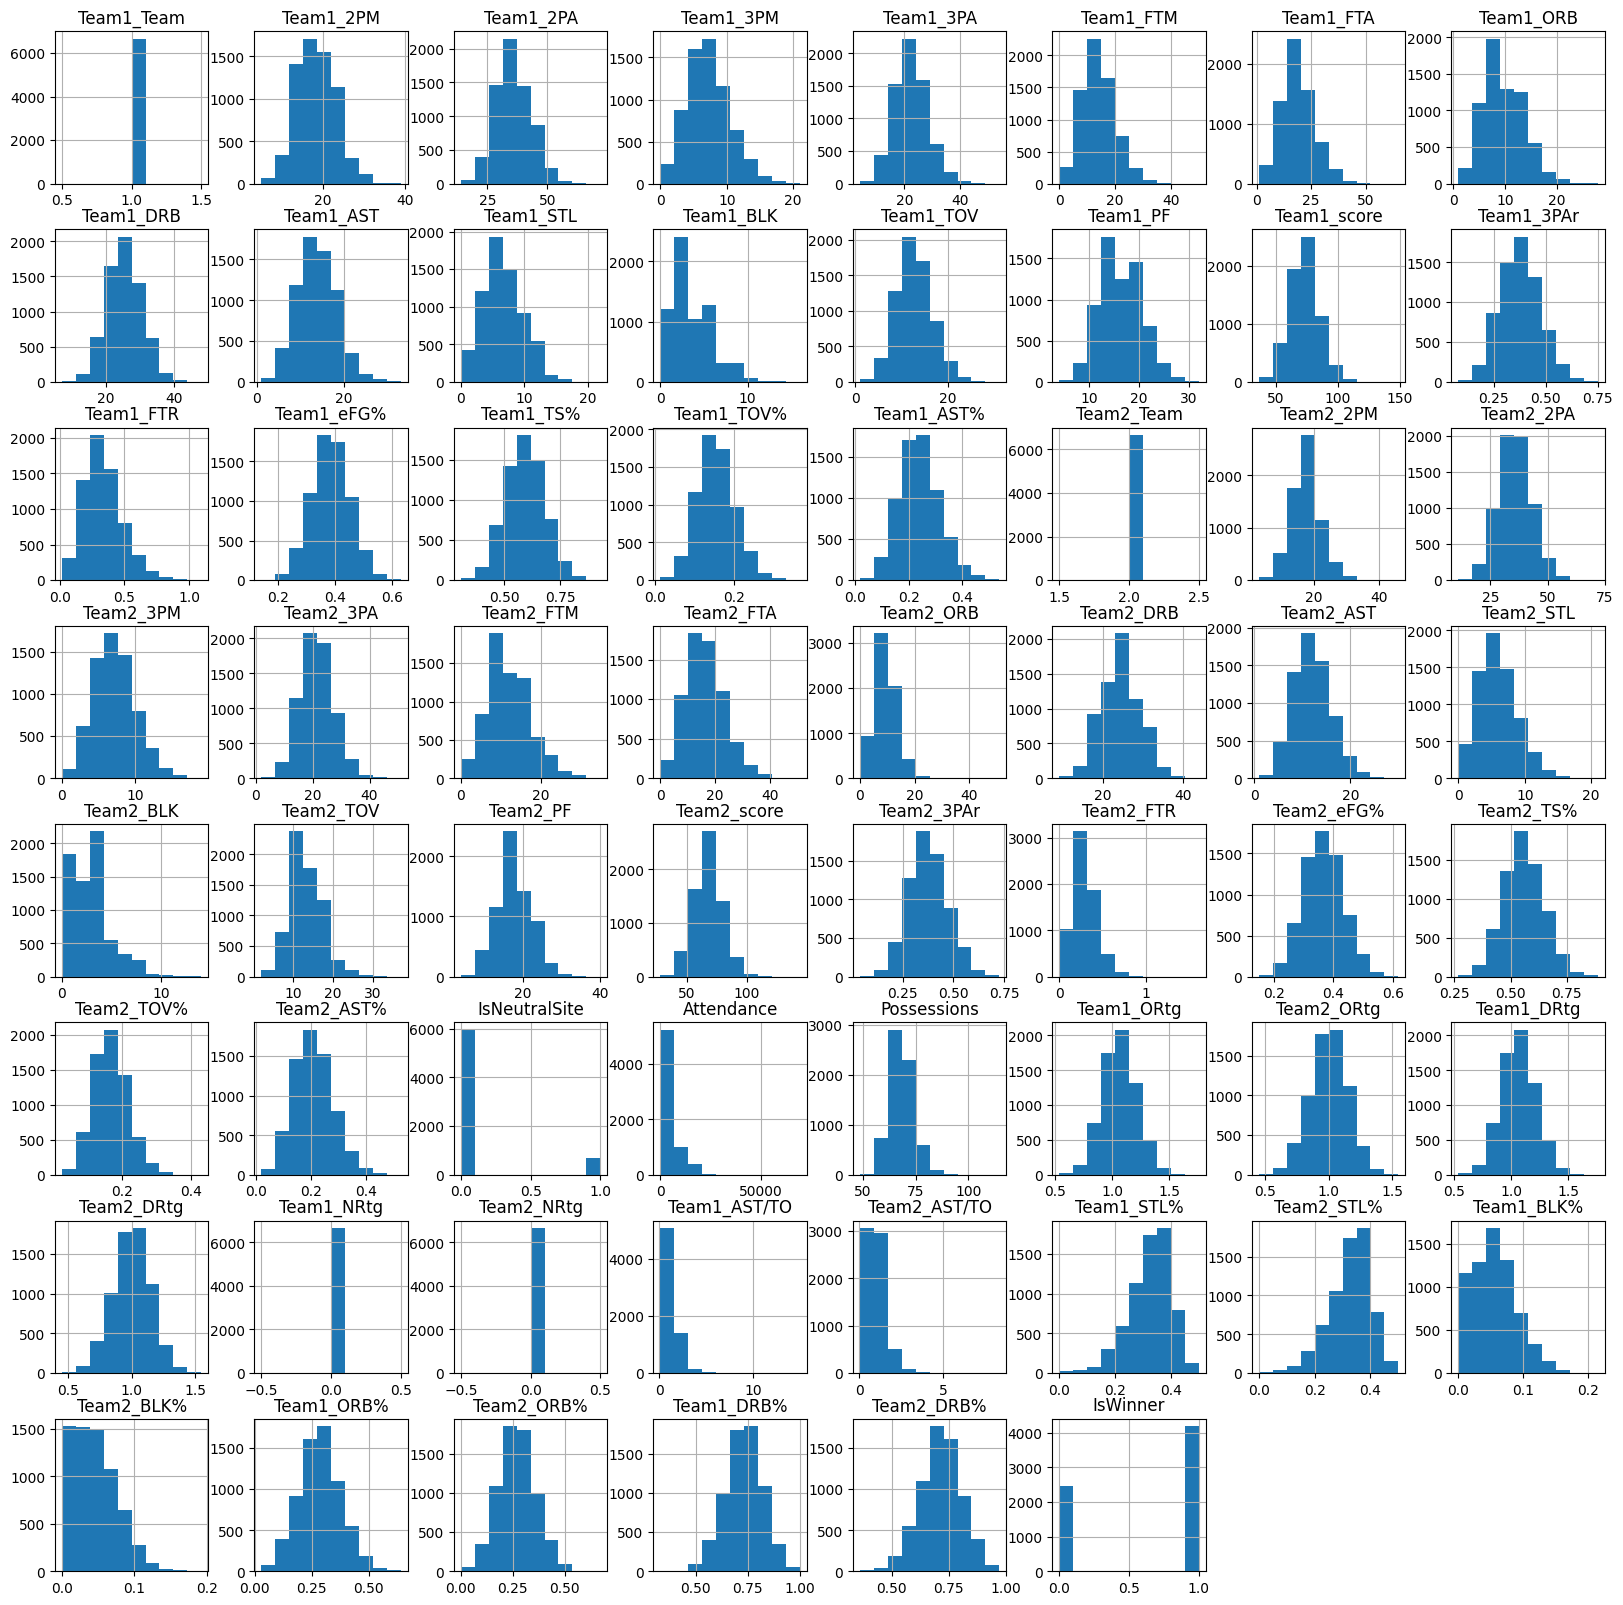

In [48]:
combined_df.hist(figsize=(20,20))
plt.show()

In [55]:
'''
Baseline Model
The "baseline" model always selects the home team as the winner. There is a notable home-court advantage, 
with the home team typically winning around 60% of their games in a given season. For my dataset, the exact value is 64.1%:
'''
# exclude the game played in neutral sites
home_game_df = combined_df[combined_df['IsNeutralSite'] == 0]
home_game_df['IsWinner'].value_counts(normalize=True)

1    0.641361
0    0.358639
Name: IsWinner, dtype: float64

In [56]:
# create results and residuals df to hold modeling results
results_df = pd.DataFrame(columns=['model_name', 'cv_score', 'gs_score', 'train_score', 'test_score'])
residuals_df = pd.DataFrame(columns=['y_true'])
residuals_df['y_true'] = combined_df['IsWinner']

In [64]:
class ModelEval():
    '''
    A pipeline to process data, perform cross validation and grid search,
    fit model, calculate model predictions and accuracy, create confidence matrix,
    and log results.
    
    Parameters
    ----------
    model : an instantiated scikit-learn model object.
    
    model_name : a string with the model name
    
    results_df : dataframe to hold the results for each successive model
    
    residuals_df : dataframe to hold the predictions for each successive model
    
    stats : X_train, X_test, y_train, y_test from sklearn.model_selection.train_test_split
    
    param_grid : the parameter grid used in the model grid search
    
    scaler : a 'yes'/'no' string indicating whether the model requires
             scaling the data with sklearn.preprocessing.StandardScaler
    
    pca : a 'yes'/'no' string indicating whether or not to perform scaling and PCA on the data.
    '''
    
    def __init__(self, model, model_name, results_df, residuals_df, stats, param_grid, scaler='no', pca='no', n_components=None):
        
        self.model = model
        self.model_name = model_name
        self.results_df = results_df
        self.residuals_df = residuals_df
        self.X_train, self.X_test, self.y_train, self.y_test = stats
        self.param_grid = param_grid
        self.cv_score = None
        self.gs_score = None
        
        if scaler == 'yes':
            scaler = StandardScaler()
            self.X_train = scaler.fit_transform(self.X_train)
            self.X_test = scaler.transform(self.X_test)
            
        if pca == 'yes':
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(self.X_train)
            X_test_scaled = scaler.transform(self.X_test)

            pca = PCA(n_components=n_components)
            X_train_pca = pca.fit_transform(X_train_scaled)
            X_test_pca = pca.transform(X_test_scaled)
            
            self.X_train = X_train_pca
            self.X_test = X_test_pca

            self.explained_variance = sum(pca.explained_variance_ratio_)
    
    def calc_cv(self):
        
        cv_scores = cross_val_score(self.model, self.X_train, self.y_train, cv=3)
        self.cv_score = cv_scores.mean()
        self.fitted_model = self.model.fit(self.X_train, self.y_train)
    
    def calc_grid_search(self):
        
        grid_search = GridSearchCV(self.model, self.param_grid, cv=3)
        self.fitted_model = grid_search.fit(self.X_train, self.y_train)
        self.params_model = grid_search.best_estimator_
        self.gs_score = grid_search.best_score_
        
    def calc_train_preds(self):
        
        self.train_preds = self.fitted_model.predict(self.X_train)
    
    def calc_test_preds(self):
        
        self.test_preds = self.fitted_model.predict(self.X_test)
    
    def calc_train_score(self):
        
        self.train_score = self.fitted_model.score(self.X_train, self.y_train)
    
    def calc_test_score(self):
    
        self.test_score = self.fitted_model.score(self.X_test, self.y_test)
    
    def create_conf_matrix(self):
        conf_matrix = confusion_matrix(y_true=self.y_test, y_pred=self.test_preds)
        self.disp = ConfusionMatrixDisplay(conf_matrix)
        return self.disp.plot()
    
    def record_results(self):
        
        idx = self.results_df.shape[0]
        results_df.loc[idx] = [self.model_name, self.cv_score, self.gs_score, self.train_score, self.test_score]
    
    def calc_residuals(self):
        
        train_preds_df = pd.DataFrame(self.train_preds, index=self.y_train.index)
        test_preds_df = pd.DataFrame(self.test_preds, index=self.y_test.index)
        
        self.model_preds = pd.concat([train_preds_df, test_preds_df]).sort_index()
        
        self.residuals_df[f'{self.model_name}' + '_residuals'] = self.residuals_df['y_true'] - self.model_preds[0]
    
    def full_diag(self):
        
        if self.param_grid == None:   
            self.calc_cv()
        else:
            self.calc_grid_search()
            
        self.calc_train_preds()
        self.calc_test_preds()
        self.calc_train_score()
        self.calc_test_score()
        self.create_conf_matrix()
        self.record_results()
        self.calc_residuals()

In [111]:
# 4. Preparing Training Data
# Define features and target variable
features = ['Attendance', 'IsNeutralSite', 'Team1_3PAr', 'Team1_FTR', 'Team1_eFG%', 'Team1_TS%', 'Team1_TOV%', 'Team1_AST%', 'Team1_ORtg', 'Team1_DRtg', 'Team1_NRtg', 'Team1_AST/TO', 'Team1_STL%', 'Team1_BLK%', 'Team1_ORB%', 'Team1_DRB%',
             'Team2_3PAr', 'Team2_FTR', 'Team2_eFG%', 'Team2_TS%', 'Team2_TOV%', 'Team2_AST%', 'Team2_ORtg', 'Team2_DRtg', 'Team2_NRtg', 'Team2_AST/TO', 'Team2_STL%', 'Team2_BLK%', 'Team2_ORB%', 'Team2_DRB%']
target = 'IsWinner'  # 1 if Team 1 wins, 0 if Team 2 wins

In [112]:
# Assuming we have a winner column, split the dataset into train and validation sets
# using every columns except the target column and fixturekey as features
X = combined_df[features]
y = combined_df[target]
stats = train_test_split(X, y, test_size=0.2, random_state=42)

/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was re

,model_name,cv_score,gs_score,train_score,test_score
0,log_4F_8var_10,0.97973,NaN,0.986486,0.981245
1,log_28var,0.97973,NaN,0.986486,0.981245
2,log_gs_28var,NaN,1.0,1.000000,1.000000
3,log_28var,0.97973,None,0.986486,0.981245
4,RFC_28var,0.97973,None,0.986486,0.981245
5,log_gs_28var,NaN,1.0,1.000000,1.000000


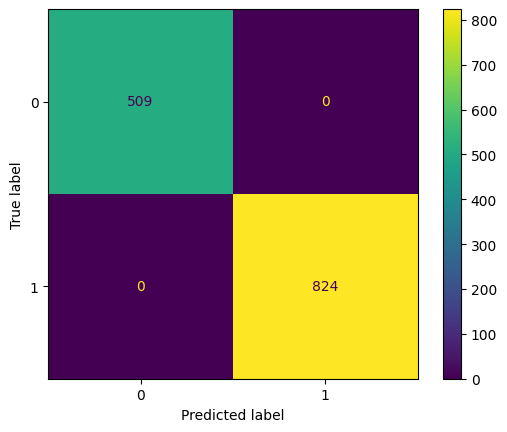

In [113]:
# 5. Model Building
# Using a LogisticRegression for prediction
log_gs = LogisticRegression(solver='saga', random_state=42)
log_param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', None],
    'C': [0.01, 0.1, 1.0,],
}

log_gs_model = ModelEval(log_gs, 'log_gs_28var', results_df, residuals_df, stats, log_param_grid, scaler='yes')
log_gs_model.full_diag()

results_df

In [114]:
log_gs_model.params_model

LogisticRegression(C=0.1, penalty='l1', random_state=42, solver='saga')

,model_name,cv_score,gs_score,train_score,test_score
0,log_4F_8var_10,0.97973,NaN,0.986486,0.981245
1,log_28var,0.97973,NaN,0.986486,0.981245
2,log_gs_28var,NaN,1.0,1.000000,1.000000
3,log_28var,0.97973,None,0.986486,0.981245
4,RFC_28var,0.97973,None,0.986486,0.981245
5,log_gs_28var,NaN,1.0,1.000000,1.000000
6,RFC_28var,NaN,0.990616,1.000000,0.986497
7,RFC_28var,NaN,0.993243,0.999062,0.987997


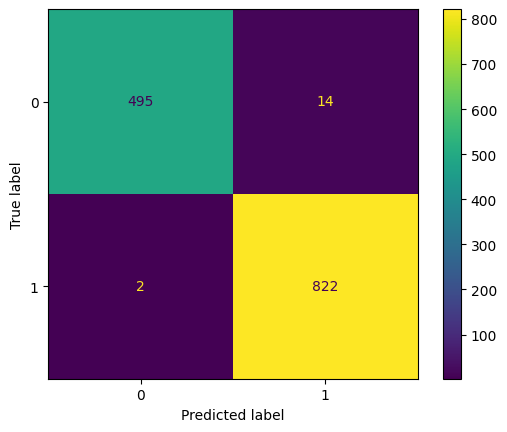

In [117]:
# Using a RandomForestClassifier for prediction
RFC = RandomForestClassifier(n_estimators=100, random_state=42)
RFC_param_grid = {
    'criterion': ['gini'],
    'n_estimators': [175, 200],
    'max_depth': [5, 7],
    'min_samples_split': [2],
    'min_samples_leaf': [3, 4],
    'max_features': ['sqrt', None]
}
# train and evaluate the model
RFC_gs_model = ModelEval(RFC, 'RFC_28var', results_df, residuals_df, stats, RFC_param_grid, scaler='yes')
RFC_gs_model.full_diag()

results_df

In [118]:
RFC_gs_model.params_model

RandomForestClassifier(max_depth=7, max_features=None, min_samples_leaf=3,
                       n_estimators=175, random_state=42)

,model_name,cv_score,gs_score,train_score,test_score
0,log_4F_8var_10,0.979730,NaN,0.986486,0.981245
1,log_28var,0.979730,NaN,0.986486,0.981245
2,log_gs_28var,NaN,1.0,1.000000,1.000000
3,log_28var,0.979730,None,0.986486,0.981245
4,RFC_28var,0.979730,None,0.986486,0.981245
5,log_gs_28var,NaN,1.0,1.000000,1.000000
6,RFC_28var,NaN,0.990616,1.000000,0.986497
7,RFC_28var,NaN,0.993243,0.999062,0.987997
8,GNB_28var,0.919482,None,0.920796,0.904726


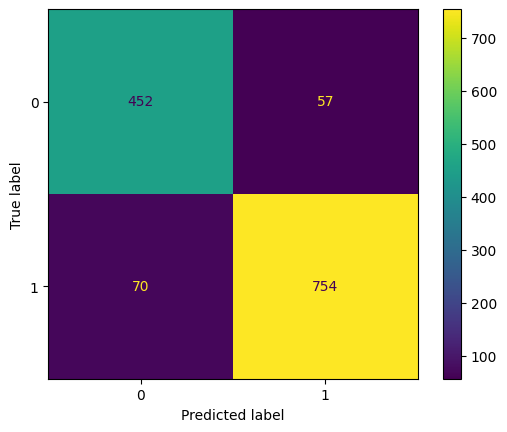

In [119]:
# Using a GaussianNB for prediction
GNB = GaussianNB()

# train and evaluate the model
GNB_model = ModelEval(GNB, 'GNB_28var', results_df, residuals_df, stats, None)
GNB_model.full_diag()

results_df

In [122]:
X = combined_df[features]
y = combined_df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

/opt/homebrew/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [10 24] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/homebrew/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/opt/homebrew/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [10 24] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/homebrew/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/opt/homebrew/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [10 24] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, User

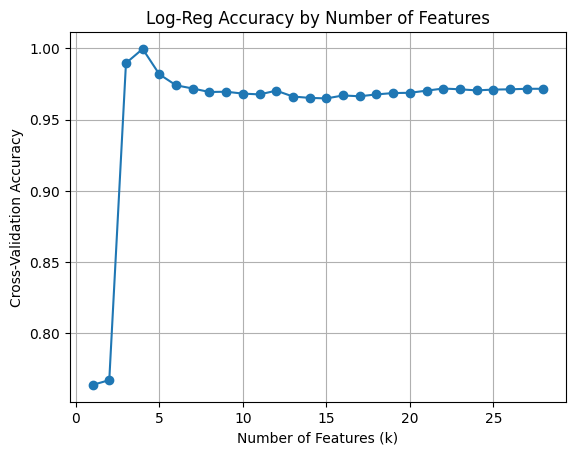

In [131]:
# To improve the model, I will use a pipeline to scale the data and perform feature selection using SelectKBest
pipe = Pipeline([
    ('scaling', StandardScaler()),
    ('feature_selection', SelectKBest(score_func=f_classif)),
    ('lr', LogisticRegression(C=0.01, random_state=99, solver='saga'))
])

# List of values of k to test
k_values = np.arange(1, 29)

# store cross-validation scores for each value of k
cv_scores = []

# perform cross-validation for different values of k
for k in k_values:
    pipe.set_params(feature_selection__k=k)
    scores = cross_val_score(pipe, X_train, y_train, cv=3)
    cv_scores.append(np.mean(scores))

# lot results
plt.plot(k_values, cv_scores, marker='o')
plt.title('Log-Reg Accuracy by Number of Features')
plt.xlabel('Number of Features (k)')
plt.ylabel('Cross-Validation Accuracy')
plt.grid(True)
plt.show();

/opt/homebrew/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [10 24] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/homebrew/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/opt/homebrew/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [10 24] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/homebrew/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/opt/homebrew/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [10 24] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, User

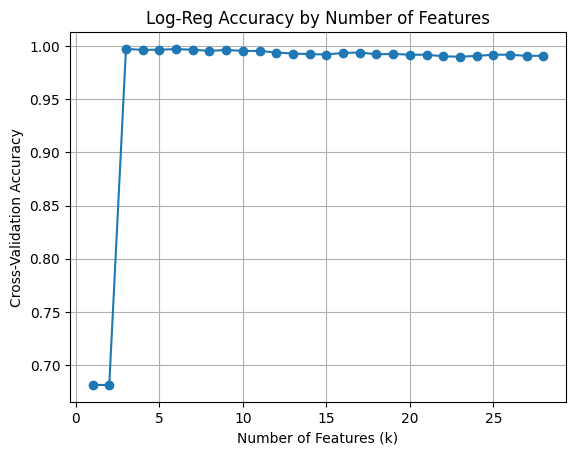

In [128]:
pipe = Pipeline([
    ('scaling', StandardScaler()),
    ('feature_selection', SelectKBest(score_func=f_classif)),
    ('RFC', RandomForestClassifier(n_estimators=100, random_state=99))
])

# List of values of k to test
k_values = np.arange(1, 29)

# store cross-validation scores for each value of k
cv_scores = []

# perform cross-validation for different values of k
for k in k_values:
    pipe.set_params(feature_selection__k=k)
    scores = cross_val_score(pipe, X_train, y_train, cv=3)
    cv_scores.append(np.mean(scores))

# lot results
plt.plot(k_values, cv_scores, marker='o')
plt.title('Log-Reg Accuracy by Number of Features')
plt.xlabel('Number of Features (k)')
plt.ylabel('Cross-Validation Accuracy')
plt.grid(True)
plt.show()

/opt/homebrew/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [10 24] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/homebrew/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/opt/homebrew/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [10 24] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/homebrew/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/opt/homebrew/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [10 24] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, User

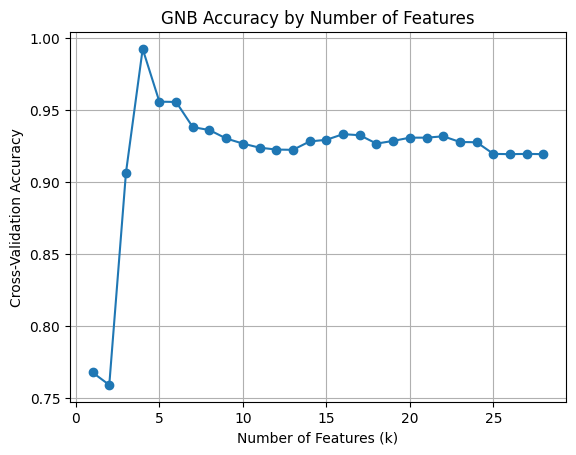

In [125]:
pipe = Pipeline([
    ('feature_selection', SelectKBest(score_func=f_classif)),
    ('gnb', GaussianNB())
])

# List of values of k to test
k_values = np.arange(1, 29)

# store cross-validation scores for each value of k
cv_scores = []

# perform cross-validation for different values of k
for k in k_values:
    pipe.set_params(feature_selection__k=k)
    scores = cross_val_score(pipe, X_train, y_train, cv=3)
    cv_scores.append(np.mean(scores))

# lot results
plt.plot(k_values, cv_scores, marker='o')
plt.title('GNB Accuracy by Number of Features')
plt.xlabel('Number of Features (k)')
plt.ylabel('Cross-Validation Accuracy')
plt.grid(True)
plt.show();

/opt/homebrew/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [10 24] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/homebrew/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


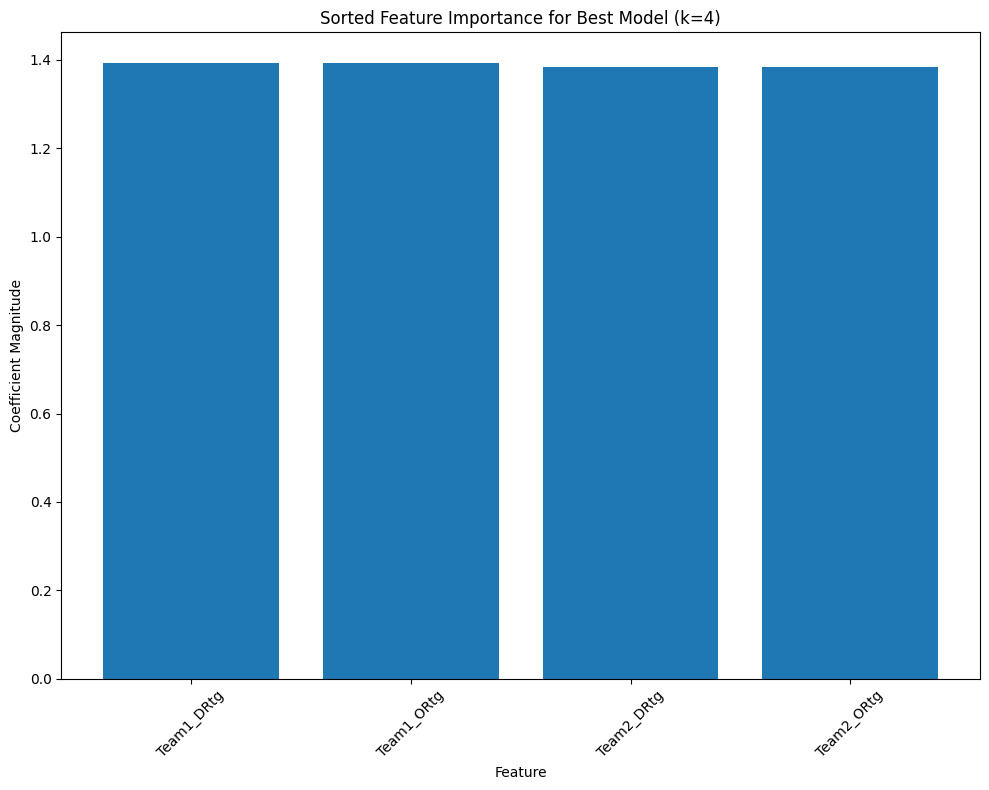

In [132]:
# identify best k value
best_k = k_values[np.argmax(cv_scores)]

# train best model on full training data
pipe.set_params(feature_selection__k=best_k)
best_model = pipe.fit(X_train, y_train)

# indices of selected features
selected_feature_indices = best_model.named_steps['feature_selection'].get_support()

# corresponding feature names
best_selected_feature_names = X.columns[selected_feature_indices]

# sort by feature importances
feature_importances = np.abs(best_model.named_steps['lr'].coef_[0])
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_feature_importances = feature_importances[sorted_indices]
sorted_feature_names = best_selected_feature_names[sorted_indices]

# plot feature importance
plt.figure(figsize=(10,8))
plt.bar(sorted_feature_names, sorted_feature_importances)
plt.title('Sorted Feature Importance for Best Model (k={})'.format(best_k))
plt.xlabel('Feature')
plt.ylabel('Coefficient Magnitude')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [139]:
log_gs = LogisticRegression(solver='saga', random_state=42)
log_param_grid = {
    'penalty': ['l1'],
    'C': [0.1],
}
log_grid_search = GridSearchCV(log_gs, log_param_grid, cv=3)

log_gs_model = log_grid_search.fit (X_train, y_train)


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [140]:
RFC = RandomForestClassifier(n_estimators=100, random_state=42)
RFC_param_grid = {
    'criterion': ['gini'],
    'n_estimators': [175],
    'max_depth': [7],
    'min_samples_split': [2],
    'min_samples_leaf': [3],
    'max_features': ['sqrt']
}
RFC_grid_search = GridSearchCV(RFC, RFC_param_grid, cv=3)

RFC_gs_model = RFC_grid_search.fit(X_train, y_train)

In [141]:
GNB = GaussianNB()

GNB_model = GNB.fit(X_train, y_train)

In [133]:
# 7. Predicting the Winners for Test Fixtures (25th Feb 2023)

# Split box scores into Team 1 and Team 2 data
team1_data = test_actuals[test_actuals['Team'] == 1]
team2_data = test_actuals[test_actuals['Team'] == 2]

# Rename columns to differentiate between Team 1 and Team 2 except the fiturekey
team1_data = team1_data.rename(columns=lambda x: 'Team1_' + x if x != 'FixtureKey' else x)
team2_data = team2_data.rename(columns=lambda x: 'Team2_' + x if x != 'FixtureKey' else x)
# Merge Team 1 and Team 2 data on FixtureKey
test_combined_df = pd.merge(team1_data, team2_data, on='FixtureKey')
#merge the combined_df with fixture_info
test_combined_df = pd.merge(combined_df, fixture_info)

In [134]:
# Generate features for the test set
# adding Possessions=0.5×[(Team FGA+0.44×Team FTA−Team ORB+Team TOV)+(Opponent FGA+0.44×Opponent FTA−Opponent ORB+Opponent TOV)]
test_combined_df['Possessions'] = 0.5*((test_combined_df['Team1_2PA'] + test_combined_df['Team1_3PA']+ 0.44*test_combined_df['Team1_FTA'] - test_combined_df['Team1_ORB'] + test_combined_df['Team1_TOV']) 
                                  + (test_combined_df['Team2_2PA'] + test_combined_df['Team2_3PA'] + 0.44*test_combined_df['Team2_FTA'] - test_combined_df['Team2_ORB'] + test_combined_df['Team2_TOV']))

# adding a new feature of Offensive Rating (ORtg)
test_combined_df['Team1_ORtg'] = test_combined_df['Team1_score'] / (test_combined_df['Possessions'] + 1e-5)
test_combined_df['Team2_ORtg'] = test_combined_df['Team2_score'] / (test_combined_df['Possessions'] + 1e-5)
# adding a new feature of Defensive Rating (DRtg)
test_combined_df['Team1_DRtg'] = test_combined_df['Team1_score'] / (test_combined_df['Possessions'] + 1e-5)
test_combined_df['Team2_DRtg'] = test_combined_df['Team2_score'] / (test_combined_df['Possessions'] + 1e-5)


In [147]:
# Predict the winners
test_features= ['Team1_ORtg','Team2_ORtg','Team1_DRtg','Team2_DRtg']
X_test = test_combined_df[features]
test_predictions = log_gs_model.predict(X_test)
# Create a dataframe with the predictions
test_predictions = pd.DataFrame(test_predictions, columns=['PredictedWinner'])
test_predictions['FixtureKey'] = test_combined_df['FixtureKey']
test_predictions['PredictedWinner'] = np.where(test_predictions['PredictedWinner'] == 1, 'Team 1', 'Team 2')
test_predictions = test_predictions[['FixtureKey', 'PredictedWinner']]
test_predictions.head(30)

[1 1 1 ... 1 1 1]


,FixtureKey,PredictedWinner
0,LIPSCO v A PEAY 14-Jan-2023,Team 1
1,QUENNC v A PEAY 29-Dec-2022,Team 1
2,FGCU v A PEAY 24-Feb-2023,Team 1
3,A PEAY v NO FLA 18-Feb-2023,Team 1
4,A PEAY v JVILLE 16-Feb-2023,Team 1
5,NO FLA v A PEAY 11-Dec-2021,Team 1
6,NO FLA v A PEAY 31-Dec-2022,Team 1
7,DAYTON v A PEAY 20-Nov-2021,Team 1
8,TENN v A PEAY 21-Dec-2022,Team 1
9,TENNST v A PEAY 22-Jan-2022,Team 1
